In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import pickle


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from cannon import CannonEnviroment, Actor, Critic

In [ ]:
MAX_DISTANCE = 1000
MAX_SPEED = 100
ANGLE_BOTTOM = 30
ANGLE_TOP = 60

In [ ]:
env = CannonEnviroment(MAX_DISTANCE, ANGLE_BOTTOM, ANGLE_TOP)

In [ ]:
def train_actor_critic(actor, actor_target, critic, episodes=1000, gamma=0.99, tau=0.005):

    actor_optimizer = optim.Adam(actor.parameters())
    critic_optimizer = optim.Adam(critic.parameters())

    replay_buffer = torch.tensor([], device=device)

    batch_size = 64
    T = 10

    total = 0
    total_critic = 0

    for episode in tqdm(range(episodes)):
        state = env.reset()

        action = actor(
            torch.tensor(state, dtype=torch.float).to(device).unsqueeze(0)
        )[0].detach().cpu() + torch.randn(1)

        action = torch.clip(action, min=0, max=MAX_SPEED)

        _, reward, status = env.step(action[0])
        torch.cat((
            replay_buffer.clone(),
            torch.tensor([[*state, action, reward, status]], dtype=torch.float).to(device)), 0,
                out=replay_buffer
        )

        total += reward
        if episode % 300 == 0:
            print(f"episode={episode} reward={total / 300: .2f} critic={total_critic / 300 / T}")
            total = 0
            total_critic = 0

        if status:
            continue

        if len(replay_buffer) > batch_size * 10:
            for t in range(T):
                batch = replay_buffer[torch.randint(0, len(replay_buffer), (batch_size, ))]

                states = batch[:, 0:2]
                actions = batch[:, 2].unsqueeze(1)
                rewards = batch[:, 3].unsqueeze(1)
                statuses = batch[:, 4]

                target_q = rewards
                current_q = critic(torch.hstack([states, actions]))

                critic_loss = nn.MSELoss()(current_q, target_q)
                total_critic += critic_loss.item()
                critic_optimizer.zero_grad()
                critic_loss.backward()
                critic_optimizer.step()

                new_actions = actor(states)

                actor_loss = -torch.mean(critic(torch.hstack([states, new_actions])))
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                for param, target_param in zip(actor.parameters(), actor_target.parameters()):
                    target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    return actor, actor_target, critic


Снизу в логах за каждые 300 эпизодов указаны средний reward актора и средний loss критика, вдино что они одновременно уменьшаются

In [ ]:
actor = Actor(128, 5).to(device)
critic = Critic(256, 7).to(device)

actor_target = Actor(128, 5).to(device)
actor_target.load_state_dict(actor.state_dict())

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    actor, actor_target, critic = train_actor_critic(actor, actor_target, critic, int(2e4))

# Представленный ниже результат является плодом многократных запусков и экспериментов с гиперпараметрами, самый удачный запуск

  1%|          | 121/20000 [00:00<00:16, 1193.52it/s]

episode=0 reward=-3.07 critic=0.0


  2%|▏         | 491/20000 [00:00<00:16, 1191.33it/s]

episode=300 reward=-516.37 critic=0.0


  3%|▎         | 614/20000 [00:00<00:16, 1204.36it/s]

episode=600 reward=-490.32 critic=0.0


  4%|▍         | 871/20000 [00:15<11:42, 27.23it/s]  

episode=900 reward=-246.81 critic=2037.6333153738794


  6%|▌         | 1201/20000 [00:38<21:27, 14.60it/s]

episode=1200 reward=-112.47 critic=1384.2364826863607


  8%|▊         | 1502/20000 [00:58<20:34, 14.98it/s]

episode=1500 reward=-92.59 critic=1048.8997812067669


  9%|▉         | 1802/20000 [01:18<20:44, 14.62it/s]

episode=1800 reward=-50.08 critic=945.6664391326905


 11%|█         | 2103/20000 [01:38<17:21, 17.18it/s]

episode=2100 reward=-35.05 critic=721.0348208007813


 12%|█▏        | 2403/20000 [01:57<18:53, 15.52it/s]

episode=2400 reward=-31.36 critic=593.9921556650797


 14%|█▎        | 2701/20000 [02:17<18:24, 15.66it/s]

episode=2700 reward=-32.84 critic=583.3172772801718


 15%|█▌        | 3002/20000 [02:37<16:52, 16.79it/s]

episode=3000 reward=-26.48 critic=534.0636570129394


 17%|█▋        | 3302/20000 [02:57<18:10, 15.31it/s]

episode=3300 reward=-28.71 critic=525.2684697901408


 18%|█▊        | 3602/20000 [03:16<17:46, 15.38it/s]

episode=3600 reward=-25.99 critic=494.62252663167317


 20%|█▉        | 3903/20000 [03:35<17:21, 15.45it/s]

episode=3900 reward=-27.97 critic=472.5852377166748


 21%|██        | 4203/20000 [03:55<17:08, 15.36it/s]

episode=4200 reward=-25.00 critic=429.13290179951986


 23%|██▎       | 4502/20000 [04:14<14:58, 17.25it/s]

episode=4500 reward=-23.22 critic=400.69845730336505


 24%|██▍       | 4802/20000 [04:34<17:01, 14.87it/s]

episode=4800 reward=-24.85 critic=383.9159679209391


 26%|██▌       | 5102/20000 [04:53<15:37, 15.88it/s]

episode=5100 reward=-22.85 critic=360.23127042134604


 27%|██▋       | 5403/20000 [05:12<14:59, 16.24it/s]

episode=5400 reward=-23.92 critic=354.4344966532389


 29%|██▊       | 5702/20000 [05:32<15:56, 14.95it/s]

episode=5700 reward=-23.24 critic=347.7887572784424


 30%|███       | 6003/20000 [05:51<15:13, 15.31it/s]

episode=6000 reward=-21.89 critic=325.76673313649496


 32%|███▏      | 6302/20000 [06:10<14:49, 15.39it/s]

episode=6300 reward=-23.69 critic=321.54976063283283


 33%|███▎      | 6601/20000 [06:29<13:56, 16.02it/s]

episode=6600 reward=-23.59 critic=318.4967080485026


 35%|███▍      | 6903/20000 [06:49<14:14, 15.34it/s]

episode=6900 reward=-23.25 critic=281.4050579490662


 36%|███▌      | 7203/20000 [07:08<13:34, 15.72it/s]

episode=7200 reward=-20.32 critic=170.62230480448406


 38%|███▊      | 7502/20000 [07:27<13:39, 15.25it/s]

episode=7500 reward=-20.76 critic=114.09010032049815


 39%|███▉      | 7801/20000 [07:47<10:43, 18.96it/s]

episode=7800 reward=-22.60 critic=87.36682748730978


 41%|████      | 8102/20000 [08:06<13:17, 14.91it/s]

episode=8100 reward=-19.82 critic=86.67448303127289


 42%|████▏     | 8402/20000 [08:25<12:41, 15.23it/s]

episode=8400 reward=-21.39 critic=57.65226302321752


 44%|████▎     | 8701/20000 [08:45<12:29, 15.08it/s]

episode=8700 reward=-20.24 critic=67.05765840498606


 45%|████▌     | 9001/20000 [09:04<11:52, 15.43it/s]

episode=9000 reward=-21.53 critic=66.39250923641522


 47%|████▋     | 9302/20000 [09:23<11:53, 14.99it/s]

episode=9300 reward=-19.62 critic=74.58218292013804


 48%|████▊     | 9603/20000 [09:43<11:21, 15.25it/s]

episode=9600 reward=-19.71 critic=53.6083372212251


 50%|████▉     | 9901/20000 [10:02<10:10, 16.54it/s]

episode=9900 reward=-20.34 critic=63.58215344492594


 51%|█████     | 10201/20000 [10:21<09:42, 16.82it/s]

episode=10200 reward=-19.91 critic=45.49581251970927


 53%|█████▎    | 10501/20000 [10:40<11:12, 14.13it/s]

episode=10500 reward=-16.09 critic=49.14046437855561


 54%|█████▍    | 10801/20000 [10:59<10:22, 14.77it/s]

episode=10800 reward=-15.35 critic=52.841675583283106


 56%|█████▌    | 11102/20000 [11:18<10:01, 14.79it/s]

episode=11100 reward=-17.01 critic=53.28292357436816


 57%|█████▋    | 11403/20000 [11:37<07:11, 19.91it/s]

episode=11400 reward=-14.28 critic=43.83142781925201


 59%|█████▊    | 11703/20000 [11:56<07:48, 17.73it/s]

episode=11700 reward=-13.50 critic=44.69564626336098


 60%|██████    | 12002/20000 [12:15<08:48, 15.14it/s]

episode=12000 reward=-14.76 critic=46.213753831307095


 62%|██████▏   | 12302/20000 [12:34<08:33, 14.99it/s]

episode=12300 reward=-14.27 critic=96.18686721952756


 63%|██████▎   | 12601/20000 [12:53<08:24, 14.68it/s]

episode=12600 reward=-15.85 critic=60.257256581465406


 65%|██████▍   | 12902/20000 [13:13<07:40, 15.42it/s]

episode=12900 reward=-13.40 critic=38.22564078577359


 66%|██████▌   | 13201/20000 [13:31<07:16, 15.56it/s]

episode=13200 reward=-12.95 critic=42.16024963927269


 68%|██████▊   | 13503/20000 [13:51<07:22, 14.68it/s]

episode=13500 reward=-13.17 critic=45.714385604461036


 69%|██████▉   | 13803/20000 [14:10<06:00, 17.20it/s]

episode=13800 reward=-13.35 critic=34.918234227021536


 71%|███████   | 14102/20000 [14:28<05:41, 17.28it/s]

episode=14100 reward=-11.94 critic=34.54647755424182


 72%|███████▏  | 14403/20000 [14:47<05:45, 16.20it/s]

episode=14400 reward=-12.60 critic=25.35799645749728


 74%|███████▎  | 14703/20000 [15:06<05:44, 15.39it/s]

episode=14700 reward=-14.26 critic=33.01288091437022


 75%|███████▌  | 15004/20000 [15:25<04:38, 17.91it/s]

episode=15000 reward=-14.02 critic=28.682681957761446


 77%|███████▋  | 15302/20000 [15:43<04:50, 16.19it/s]

episode=15300 reward=-13.49 critic=31.712073589245477


 78%|███████▊  | 15602/20000 [16:02<03:56, 18.60it/s]

episode=15600 reward=-13.07 critic=27.08082897035281


 80%|███████▉  | 15903/20000 [16:20<04:32, 15.04it/s]

episode=15900 reward=-12.52 critic=30.1222571195364


 81%|████████  | 16201/20000 [16:39<04:05, 15.49it/s]

episode=16200 reward=-13.90 critic=25.551487961649894


 83%|████████▎ | 16502/20000 [16:58<02:54, 20.10it/s]

episode=16500 reward=-13.19 critic=32.01344061386585


 84%|████████▍ | 16804/20000 [17:17<02:55, 18.25it/s]

episode=16800 reward=-13.07 critic=27.44611201918125


 86%|████████▌ | 17103/20000 [17:36<02:56, 16.44it/s]

episode=17100 reward=-12.35 critic=26.858853889902434


 87%|████████▋ | 17401/20000 [17:54<02:59, 14.48it/s]

episode=17400 reward=-11.74 critic=21.475972275575003


 89%|████████▊ | 17702/20000 [18:13<02:09, 17.75it/s]

episode=17700 reward=-11.97 critic=33.04115568180879


 90%|█████████ | 18002/20000 [18:32<02:11, 15.16it/s]

episode=18000 reward=-12.18 critic=19.516152480642003


 92%|█████████▏| 18301/20000 [18:51<01:54, 14.88it/s]

episode=18300 reward=-11.65 critic=25.889335212032


 93%|█████████▎| 18602/20000 [19:10<01:36, 14.46it/s]

episode=18600 reward=-14.00 critic=22.26984397383531


 95%|█████████▍| 18902/20000 [19:29<01:09, 15.72it/s]

episode=18900 reward=-13.03 critic=27.312224912881852


 96%|█████████▌| 19201/20000 [19:48<00:54, 14.58it/s]

episode=19200 reward=-12.95 critic=21.10964281801383


 98%|█████████▊| 19502/20000 [20:07<00:31, 15.60it/s]

episode=19500 reward=-12.25 critic=21.395275407592454


 99%|█████████▉| 19802/20000 [20:25<00:12, 15.67it/s]

episode=19800 reward=-12.44 critic=27.089335902174312


100%|██████████| 20000/20000 [20:38<00:00, 16.15it/s]


Протестируем нашего агента

In [ ]:
actor_target.eval()

misses = []

env = CannonEnviroment(1000)

for i in range(1000):
    state = env.reset()

    action = actor_target(torch.tensor(state, dtype=torch.float).to(device).unsqueeze(0))[0].detach().cpu()

    misses.append(env.step(action[0])[1])

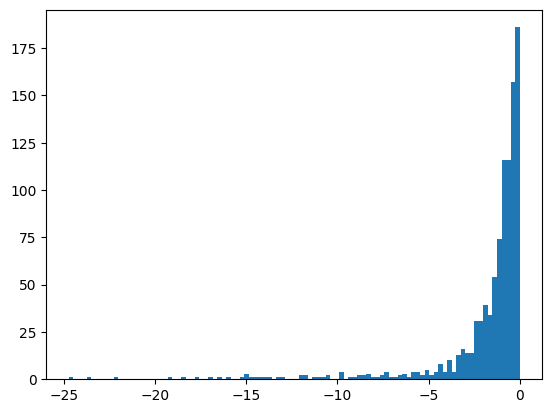

In [ ]:
plt.hist(misses, bins=100) 
plt.show() # График распределения ревардов

In [ ]:
np.mean(misses), np.median(misses), np.max(misses), np.min(misses), np.percentile(misses, 5)

(-1.7209622, -0.8163452, -0.003540039, -24.755371, -7.092984008789062)

In [ ]:
torch.save(actor_target.state_dict(), 'actor.pt')